- This notebook is mainly inspired by https://github.com/seihyoung/dfuc2024/blob/main/visualize.ipynb

In [1]:
import os
from transformers import pipeline
from transformers.image_utils import load_image

import pickle
import yaml
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from scipy import signal
import torchvision.transforms as transforms

import sys
sys.path.append("..")
sys.path.append("../models")
sys.path.append("../utils")
from dinov3backbone import DINOv3Backbone
from dinov3_utils import get_dinov3_feature

device = "cuda" if torch.cuda.is_available() else "cpu"

### Configuration

In [2]:
with open("../config/base.yaml", "r") as f:
    base_cfg = yaml.safe_load(f)

os.environ["TORCH_HOME"] = base_cfg["torch_home"]  # where to put `hub`

In [3]:
with open("../config/dinov3.yaml", "r") as f:
    dinov3_cfg = yaml.safe_load(f)

image_size = dinov3_cfg["preprocess"]["image_size"]  # each image will be resized to this size
img_transform = transforms.Compose([                 # image transformation
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dinov3_cfg["preprocess"]["mean"], std=dinov3_cfg["preprocess"]["std"]),
])

model_name = dinov3_cfg["default_model"]                           # dinov3_vits16
patch_size = dinov3_cfg["dinov3_model"][model_name]["patch_size"]  # pixel width = pixel height, determined by dinov3 model itself
n_patchs = int(image_size / patch_size)                            # each image will be divided into [n_patchs x n_patchs] patches
print(f"image_size[{image_size}]=patch_size[{patch_size}] x n_patchs[{n_patchs}]")

image_size[512]=patch_size[16] x n_patchs[32]


In [4]:
# image & mask path
v_image = "/DFU/combine_data/train/images/FUSC_0011.png"
v_mask = "/DFU/combine_data/train/labels/FUSC_0011.png"
# v_image = "/DFU/MP_data/01CMY0001/Visit 1/01CMY0001_v1_PostDebridement.JPG"
# v_mask = None

# load mask
mask = None
if v_mask is not None:
    mask = (Image.open(v_mask)#.resize((n_patchs, n_patchs), resample=Image.NEAREST)
            .convert("L"))
     
# load image & transform
image = Image.open(v_image).convert('RGB')  # convert to 3-channel image
image_t = img_transform(image)              # [3, image_size, image_size]

# load dinov3 model
dinov3_model = DINOv3Backbone(model_name=model_name, device=device, pretrained=True)
# get features
feats = get_dinov3_feature(dinov3_model, image_t, device=device)  # [embedding_dim, n_patchs, n_patchs]

Using cache found in /scratch/pxsong_root/pxsong0/qianhan/DFU/dinov3_outputs/hub/facebookresearch_dinov3_main


In [5]:
# PCA
embedding_dim = feats.shape[0]
pca_feats = feats.view(embedding_dim, -1).permute(1, 0)  # shape=[n_patchs x n_patchs, embedding_dim]

n_components = 5
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(pca_feats)
x_pca = (x_pca - x_pca.min(0)) / (x_pca.max(0) - x_pca.min(0) + 1e-5)

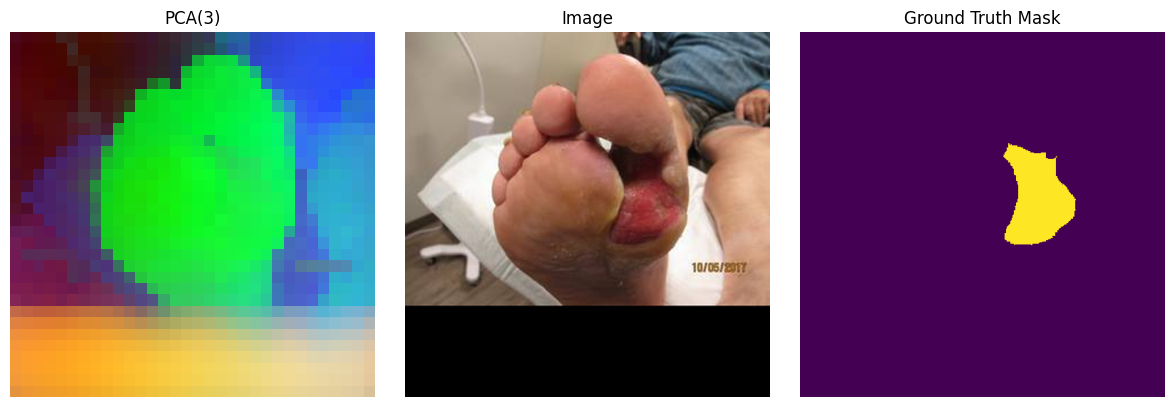

In [6]:
# 3-channel visualization
img_pca = x_pca[:, 0:3].reshape(n_patchs, n_patchs, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
imgs = [img_pca, image, mask]
titles = ['PCA(3)', 'Image', 'Ground Truth Mask']

for ax, img, title in zip(axes, imgs, titles):
    if img is None:
        ax.axis('off')
        ax.set_title("No Ground Truth Mask")
        continue
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

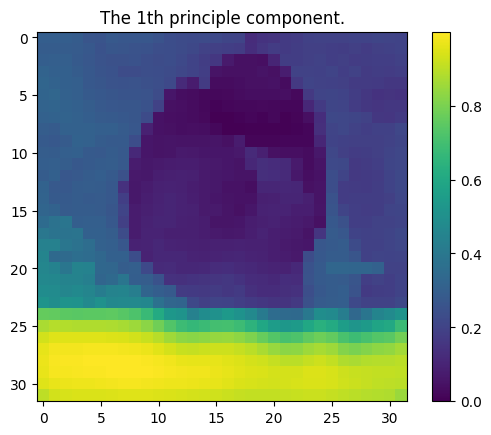

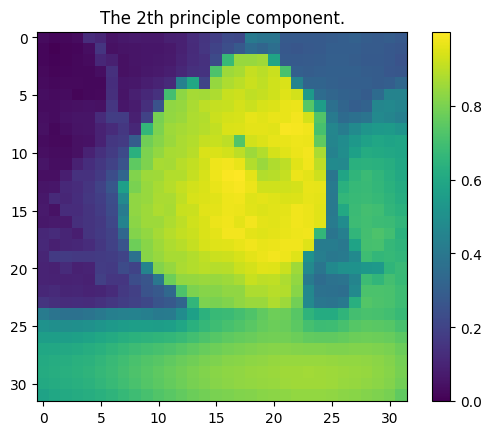

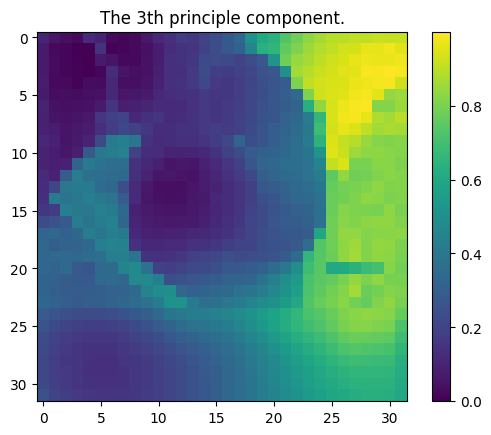

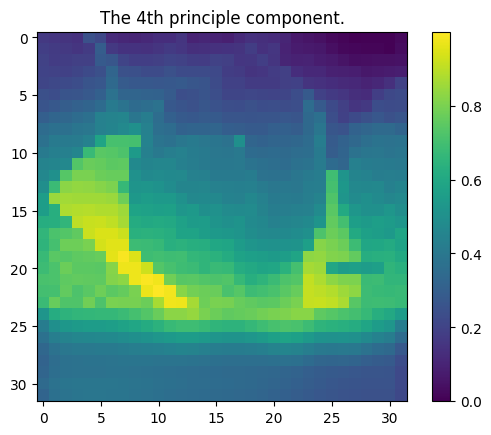

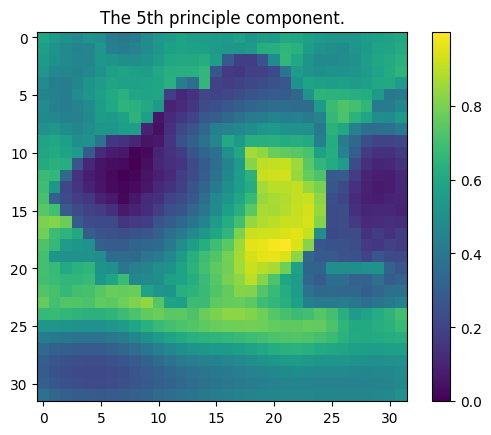

In [7]:
# visualize each component
for i in range(n_components):
    img_i = x_pca[:, i].reshape(n_patchs, n_patchs)
    plt.imshow(img_i)
    plt.title(f"The {i+1}th principle component.")
    plt.colorbar()
    plt.show()